## Gene locus summary
Author: Alexandre Pelletier and Jenny Empawi

### Motivation
Create an information visualization summarizing key information from the comprehensive AD loci table.

### Implementation
Generate one figure to highlight the most critical insights from the AD loci table. Possible information to include: effect size direction for AD risk variants wrt xQTL

#### Required Files
* xQTL_all_methods_overlap_with_AD_loci_unified_cs95orColocs_Pval1e5.csv.gz which was generated in step III from this [script](https://github.com/StatFunGen/xqtl-paper/blob/main/main_text/5_AD_xQTL_genes_cis_trans/staging/gene_priorization_table/complete_ADlocus_level_summary.R)
In this table, each row is a variant-ADlocus-Method-context-gene_name information, and so facilitate querying informations.

* [gene_prio_utils](https://github.com/StatFunGen/xqtl-paper/blob/main/main_text/5_AD_xQTL_genes_cis_trans/staging/gene_priorization_table/gene_prio_utils.R)

* AD_loci_unified_cs95orColocs.csv.gz

* gwas_n_cases_control.tsv

#### Load libraries

In [1]:
library(ggplot2)
library(patchwork)
library(RColorBrewer)

#### Set working directory and output directory

In [2]:
#setwd('/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_6') # set your working directory
#source('/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_6/gene_prio_utils.R')
#out<-'/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_6' #set your output directory
#dir.create(out) 

dir <- '/data/resource/staging_files'
source(file.path(dir, 'gene_prio_utils.R'))
out <- '/data/resource/staging_files'

16 threads available for data.table

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday()    

In [3]:
SummPanel<-function(res_adxqtloc, res_adxloc_gwas, palette=brewer.pal(8, "Pastel1"), show_size_legend = TRUE){
  # Create clean GWAS names function - plotmath
  clean_gwas_names_plotmath <- function(gwas_source) {
    case_when(
      gwas_source == "AD_Bellenguez_2022" ~ "Bellenguez~(2022)",
      gwas_source == "AD_Bellenguez_EADB_2022" ~ "bold(Bellenguez~'(2022)'~EADB)",
      gwas_source == "AD_Jansen_2021" ~ "Jansen~(2021)",
      gwas_source == "AD_Kunkle_Stage1_2019" ~ "bold(Kunkle~'(2019)')",
      gwas_source == "AD_Wightman_Excluding23andMe_2021" ~ "Wightman~(2021)~Excluding23andMe",
      gwas_source == "AD_Wightman_ExcludingUKBand23andME_2021" ~ "bold(Wightman~'(2021)'~ExcludingUKBand23andMe)",
      gwas_source == "AD_Wightman_Full_2021" ~ "Wightman~(2021)~Full",
      gwas_source == "AD_Bellenguez_EADI_2022" ~ "bold(Bellenguez~'(2022)'~EADI)",
      TRUE ~ gwas_source
    )
  }
  
  # Apply GWAS name transformation
  res_adxloc_gwas_copy <- copy(res_adxloc_gwas)
  res_adxloc_gwas_copy[, gwas_short2 := clean_gwas_names_plotmath(gwas_source)]
  
  # Filter the gwas and annot with the gene too
  res_adxloc_gwasf<-merge(res_adxloc_gwas_copy,
                          unique(res_adxqtloc[,.(locus_index,locus_gene_3,locus_gene)]),by='locus_index',allow.cartesian = TRUE)
  
  # Create the main plot
  p<-ggplot(res_adxqtloc)+
    geom_point(aes(y=locus_gene_3,x=context_group,
                   size=n_study_group.locus,
                   col=confidence_cat_group))+
    facet_grid(chr~'',scales = 'free',space = 'free')+
    scale_size(range = c(1.5,5),breaks = c(2,7,12))+theme_minimal()+
    scale_x_discrete(guide = guide_axis(angle = 90))+
    theme(strip.text.x = element_text(angle = 90))+
    xlab("xQTL groups") +
    scale_color_manual(values = c('brown1','deepskyblue4','darkseagreen3'))+ 
    scale_y_discrete(labels = scales::label_parse())+
    theme(strip.text.x = element_text(angle = 90),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())
  
  # Conditionally add size legend
  if(show_size_legend) {
    p <- p + labs(size='# Datasets', col='Confidence level')
  } else {
    p <- p + labs(col='Confidence level') + guides(size = "none")
  }
  
  # GWAS plot
  g<-ggplot(res_adxloc_gwasf)+
    geom_point(aes(y=locus_gene_3,x=gwas_short2,
                   col=gwas_sig),size=1,shape=15)+
    facet_grid(chr~'',scales = 'free',space = 'free')+
    theme_minimal()+
    scale_x_discrete(guide = guide_axis(angle = 90), labels = scales::label_parse())+
    scale_y_discrete(labels = scales::label_parse())+
    scale_color_manual(
      values = c('grey','bisque3','orange3','brown4'),
      labels = c("p>1e-5 and colocalized", "p<1e-5", "p<1e-6","p<5e-8")
    )+
    labs(col = "GWAS significance") +
    xlab("AD GWAS") +
    theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1, vjust = 0.5),
          axis.text.y = element_blank(),
          axis.title.y = element_blank(),
          strip.text = element_blank(),
          strip.background = element_blank())
  
  # Locus number plot
  colors <- data.table(locus_index=unique(res_adxqtloc$locus_index),
                       color=palette)
  
  l<-ggplot(unique(res_adxqtloc, by=c('locus_gene_3')),
            aes(x=0,y=locus_gene_3))+
    geom_tile(aes(fill=as.factor(locus_index)))+
    scale_fill_manual(values = setNames(colors$color,as.character(colors$locus_index)))+
    geom_text(aes(label=locus_index),size=2, fontface="plain")+
    facet_grid(chr~'',scales = 'free',space = 'free')+
    theme_minimal()+
    scale_y_discrete(labels = scales::label_parse())+
    theme(axis.text.y = element_text(size=6),
          axis.title.y = element_blank(), 
          strip.text = element_blank(),
          strip.background = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          legend.position = "none")
  
  return(list(l,g,p))
}

In [4]:
# update table figure
res_adx<-fread(fp(out,'xQTL_all_methods_overlap_with_AD_loci_unified_cs95orColocs_Pval1e5.csv.gz'))
res_adx<-res_adx[Method!='trans_finemapping']

# add the confidence level
res_adx[,top_confidence:=str_extract(xQTL_effects,'CL[0-9]')]

# xQTL evidence summary dot plot at locus level
# for each QTL evidence type put in 3 cat : absent, present, high, 
# for fp: high if cs95, coloc : high if npc > 0.95, TWAS: MR
table(res_adx$Method)
table(res_adx$context_short)
table(res_adx$context)


       AD_GWAS_finemapping     AD_meta_colocalization 
                      6552                       7825 
    AD_xQTL_colocalization           APOE interaction 
                    142480                       2900 
                     Coloc                         QR 
                     18653                     236849 
                   TWAS/MR                      cTWAS 
                      2689                        118 
        fSuSiE_finemapping           msex interaction 
                     14878                         23 
 multi_context_finemapping     multi_gene_finemapping 
                    106658                      70541 
single_context_finemapping                    sn_sQTL 
                   1513680                     233527 


              Ast caQTL    Ast eQTL    Ast sQTL           B    Exc eQTL 
      17708           6      117630       13522       10551      141464 
   Exc sQTL    Inh eQTL    Inh sQTL           J           K   Mic caQTL 
     166055      144615       25078         672        1118          12 
   Mic eQTL    Mic sQTL    OPC eQTL    OPC sQTL    Oli eQTL    Oli sQTL 
      58478           2       84874        8960      140034       19910 
          W   bMac eQTL   bMic eQTL  bMono eQTL   bulk eQTL  bulk gpQTL 
      40897       51782       48336       23204      831822        3689 
 bulk haQTL   bulk mQTL bulk p-sQTL   bulk pQTL   bulk sQTL bulk u-sQTL 
        212       15593      178094       17409      167790       27856 


                                                                AC_DeJager_eQTL 
                                  17708                                  133098 
                     AD_Bellenguez_2022                 AD_Bellenguez_EADB_2022 
                                   8517                                    2017 
                AD_Bellenguez_EADI_2022                          AD_Jansen_2021 
                                     17                                     672 
                  AD_Kunkle_Stage1_2019       AD_Wightman_Excluding23andMe_2021 
                                   1118                                   22223 
AD_Wightman_ExcludingUKBand23andME_2021                   AD_Wightman_Full_2021 
                                  15493                                    3181 
                     Ast_10_Kellis_eQTL                        Ast_DeJager_eQTL 
                                  21100                                   64941 
                        Ast

In [5]:
res_adx[,genomewide_sig_gene:=any(min_pval<5e-8,na.rm = T),by='gene_name']

res_adx[,n_gwas_gene:=strsplit(gwas_sources,'\\|')|>unlist()|>unique()|>length(),by=.(gene_name)]
res_adx[,n_gwas_locus:=strsplit(gwas_sources,'\\|')|>unlist()|>unique()|>length(),by=.(locus_index)]

res_adx[is.na(APOE_region),APOE_region:=FALSE]

res_adx[,APOE_region.gene:=any(APOE_region),by='gene_name']


res_adx[,chr:=seqid(ADlocusID[1],only_num = T),by=.(ADlocusID)]

res_adx[,MAPT_region:=chr==17&pos>45307498 &pos> 46836265]
res_adx[is.na(MAPT_region),MAPT_region:=FALSE]

res_adx[,MAPT_region.locus:=any(MAPT_region),by='locus_index']

#get at locus level and cis information only
res_adxloc<-unique(res_adx[Method!='trans_finemapping'][!context_short%in%c('B','J','K','W')][order(locus_gene,confidence_lvl,cV2F_rank)],by=c('locus_gene','context'))

#top gene per locus
res_adxloc[gene_name!='',n.study.gene.locus:=length(unique(context)),by=.(gene_name,locus_index)]

res_adxloc[gene_name!='',top_gene:=gene_name==gene_name[order(confidence_lvl,-n.study.gene.locus,cV2F_rank)][1],by=.(locus_index)]
res_adxloc[gene_name!='',top_genes:=gene_name%in%gene_name[confidence_lvl%in%c('CL1','CL2','CL3')|confidence_lvl%in%sort(confidence_lvl)[1]],by=.(locus_index)]


#TopGenes per locus####
res_adxlocge<-res_adxloc[context_short!=''][order(locus_index,cV2F_rank)][(top_genes)]
unique(res_adxlocge$locus_index)|>length() #177
unique(res_adxlocge$gene_name)|>length()#283>304/576


[1] 177

[1] 304

In [6]:
res_adxlocge[,context_group:=ifelse(context_short%in%c('bMono eQTL','bMac eQTL','bMic eQTL'),'Immune eQTL',
                                     ifelse(context_short%in%c( 'bulk p-sQTL','bulk u-sQTL','bulk a-sQTL'),'bulk sQTL',
                                            ifelse(context_short%in%c('bulk pQTL','bulk gpQTL'),'bulk (g)pQTL',
                                                   ifelse(context_short%in%c('bulk haQTL','bulk mQTL'),'bulk epiQTL',as.character(context_short)))))]


unique(res_adxlocge$context_group)

unique(res_adxlocge[order(confidence_lvl)],by='gene_name')$confidence_lvl|>table()


# summarize using confidence score  and nstudy
res_adxlocge[,n_study_group:=length(unique(context)),by=.(gene_name,context_group)]
res_adxlocge[,confidence_lvl_group:=sort(confidence_lvl)[1],by=.(gene_name,context_group)]
table(res_adxlocge$confidence_lvl_group)
res_adxlocge[,n_loci_gene:=unique(locus_index)|>length(),by=.(gene_name)]
res_adxlocge[,chr:=seqid(variant_ID[!is.na(variant_ID)][1],only_num = T),by=.(locus_index)]
res_adxlocge[is.na(chr),chr:=`#chr`]
table(res_adxlocge$confidence_lvl_group)


res_adxlocge[,n_study_group.locus:=length(unique(context)),by=.(gene_name,locus_index,context_group)]
res_adxlocge[,confidence_lvl_group.locus:=sort(confidence_lvl)[1],by=.(gene_name,locus_index,context_group)]


#fwrite(res_adxlocge,fp(out,'res_summ_top_gene_by_locus.csv.gz'))
#res_adxlocge<-fread(fp(out,'res_summ_top_gene_by_locus.csv.gz'))


[1] "bulk eQTL"    "Immune eQTL"  "Ast eQTL"     "bulk sQTL"    "Exc eQTL"    
 [6] "Oli eQTL"     "Oli sQTL"     "bulk epiQTL"  "Inh eQTL"     "OPC eQTL"    
[11] "Exc sQTL"     "Mic eQTL"     "bulk (g)pQTL" "Inh sQTL"     "Ast sQTL"    
[16] "OPC sQTL"     "Mic caQTL"    "Ast caQTL"


CL1 CL2 CL3 CL4 CL5 CL6 
 22  22  39  18 196   7 


 CL1  CL2  CL3  CL4  CL5  CL6 
 177  140  366  111 1109  153 

Warning message in `[.data.table`(res_adxlocge, is.na(chr), `:=`(chr, `#chr`)):
“Coercing 'character' RHS to 'integer' to match the type of column 155 named 'chr'.”



 CL1  CL2  CL3  CL4  CL5  CL6 
 177  140  366  111 1109  153 

In [7]:
contexts_order<-c('Exc eQTL','Exc sQTL',
                  'Inh eQTL','Inh sQTL',
                  'Oli eQTL','Oli sQTL',
                  'OPC eQTL','OPC sQTL',
                  'Ast eQTL','Ast caQTL','Ast sQTL',
                  'Mic eQTL','Mic caQTL',
                  'Immune eQTL',
                  'bulk eQTL',
                  'bulk sQTL',
                  'bulk (g)pQTL',
                  'bulk epiQTL')
setdiff(res_adxlocge$context_group,contexts_order)
res_adxlocge[,context_group:=factor(context_group,levels = contexts_order)]


res_adxlocgef<-res_adxlocge[(genomewide_sig_gene)]

unique(res_adxlocgef$locus_index)|>length() #98
unique(res_adxlocgef$gene_name)|>length()#79> 116 >134

unique(res_adxlocgef$locus_gene)|>length()#98> 138 >156
unique(res_adxlocgef[!(APOE_region.gene)]$locus_gene)|>length()#86>122>140


# extract each locus
res_adxlocge_cont_top<-unique(res_adxlocgef,by=c('gene_name','context_group','locus_index'))[gene_name%in%gene_name[confidence_lvl_group.locus%in%c('CL1','CL2','CL3','CL4','CL5')]]

character(0)

[1] 98

[1] 134

[1] 156

[1] 140

In [8]:
#sep causal vs correlated and remove all C6
#C6 is dropped
res_adxlocge_cont_topf<-res_adxlocge_cont_top[confidence_lvl_group.locus!='CL6']
#sep in 3categories
res_adxlocge_cont_topf[,confidence_cat_group:=ifelse(confidence_lvl_group.locus%in%c('CL1',"CL2"),'Putative causal (CL1, CL2)',ifelse(confidence_lvl_group.locus=='CL3','Putative causal (CL3)','Associated (CL4, CL5)'))]
res_adxlocge_cont_topf[,confidence_cat_group:=factor(confidence_cat_group,levels = c('Putative causal (CL1, CL2)','Putative causal (CL3)','Associated (CL4, CL5)'))]

In [9]:
#add GWAS signals
res_ad<-fread(fp(out,'AD_loci_unified_cs95orColocs.csv.gz'))
res_ad<-merge(res_ad,unique(res_adx[,.(locus_index,ADlocusID)]))

res_ad[,gwas_pvalue:=getPval(gwas_zscore)]

res_adxloc_gwas<-unique(res_ad[order(gwas_pvalue)][gwas_source!=''],by=c('locus_index','gwas_source'))
res_adxloc_gwas[,chr:=str_extract(chr,'[0-9]+')|>as.numeric()]

res_adxloc_gwas[,gwas_pvalue10:=ifelse(gwas_pvalue>1e-10,gwas_pvalue,1e-10)]
res_adxloc_gwas[,gwas_sig:=ifelse(gwas_pvalue<5e-8,'p<5e-8',ifelse(gwas_pvalue<1e-6,'p<1e-6',ifelse(gwas_pvalue<1e-5,'p<1e-5',
                                                                                                      'p>1e-5 but coloc')))]
res_adxloc_gwas[is.na(gwas_sig),gwas_sig:='p>1e-5 but coloc']
res_adxloc_gwas[,gwas_sig:=factor(gwas_sig,levels=c('p>1e-5 but coloc','p<1e-5','p<1e-6','p<5e-8'))]


res_adxloc_gwas[,gwas_short:=str_extract(gwas_source,'Bellenguez|Jansen|Kunkle|Wightman')]
table(res_adxloc_gwas$gwas_short)
res_adxloc_gwas[str_detect(gwas_source,'EADB|EADI|UKB|23andMe'),gwas_short:=paste(gwas_short,str_extract(gwas_source,'EADB|EADI|UKB|23andMe'),sep='_')]
res_adxloc_gwas[gwas_short=='Wightman_23andMe',gwas_short:='Wightman_no23andMe']
res_adxloc_gwas[gwas_short=='Wightman_UKB',gwas_short:='Wightman_no23AndUKB']



Bellenguez     Jansen     Kunkle   Wightman 
       180         36         42        211 

In [10]:
#order by n AD cases (non AD by proxi first) 
res_adxloc_gwas[,ad_by_proxi:=!gwas_source%in%c('AD_Bellenguez_EADB_2022','AD_Bellenguez_EADI_2022',
                                          'AD_Wightman_ExcludingUKBand23andME_2021',
                                          'AD_Kunkle_Stage1_2019'),by='locus_index']
gwmt<-fread(fp(out,'gwas_n_cases_control.tsv'))
res_adxloc_gwas<-merge(res_adxloc_gwas,gwmt[,.(gwas_source=study_id,n_case,n_control)])
#bold if not from AD by proxy - FIXED: use plotmath ~ for spaces
res_adxloc_gwas[,gwas_short2:=ifelse(!ad_by_proxi,
                                    paste0("bold(", gsub(" ", "~", gwas_short), ")"), 
                                    gsub(" ", "~", gwas_short))]
res_adxloc_gwas[,gwas_short2:=factor(gwas_short2,levels = unique(gwas_short2[order(ad_by_proxi,-n_case)]))]
levels(res_adxloc_gwas$gwas_short2)
# Get proxy status for loci to use with genes
locus_proxy_status <- unique(res_adxloc_gwas[, .(locus_index, ad_by_proxi)])
#annot genes - JUST gene name, no _number
res_adxlocge_cont_topf[,locus_gene_2:=gene_name, by=.(gene_name)]  # Just gene name, no numbering
# Add proxy status to genes data
res_adxlocge_cont_topf[locus_proxy_status, ad_by_proxi := i.ad_by_proxi, on = 'locus_index']

res_adxlocge_cont_topf[,locus_gene_2:={
  base_text <- gene_name[1]  # Just the gene name
  is_bold <- !ad_by_proxi[1]  # Use proxy status directly
  
  # Apply bold if needed - wrap in quotes to bold numbers too
  if(is_bold) {
    paste0("bold('", base_text, "')")
  } else {
    base_text
  }
}, by='locus_gene']
#order per gene tss and locus position - use original gene_name for ordering
res_adxlocge_cont_topf[,locus_gene_3:=factor(locus_gene_2,levels = unique(locus_gene_2[order(-chr,-tss)]))]
#filter the gwas and annot with the gene too
res_adxloc_gwasf<-merge(res_adxloc_gwas,unique(res_adxlocge_cont_topf[!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))][,.(locus_index,locus_gene_3,locus_gene)]),by='locus_index')
# clean gwas_source name - FIXED: use plotmath ~ instead of quotes
clean_gwas_names_plotmath <- function(gwas_source) {
  case_when(
    gwas_source == "AD_Bellenguez_2022" ~ "Bellenguez~(2022)",
    gwas_source == "AD_Bellenguez_EADB_2022" ~ "bold(Bellenguez~`(2022)`~EADB)",
    gwas_source == "AD_Bellenguez_EADI_2022" ~ "bold(Bellenguez~`(2022)`~EADI)",
    gwas_source == "AD_Jansen_2021" ~ "Jansen~(2021)",
    gwas_source == "AD_Kunkle_Stage1_2019" ~ "bold(Kunkle~`(2019)`)",
    gwas_source == "AD_Wightman_Excluding23andMe_2021" ~ "Wightman~(2021)~no23andMe",
    gwas_source == "AD_Wightman_ExcludingUKBand23andME_2021" ~ "bold(Wightman~`(2021)`~no23AndUKB)",
    gwas_source == "AD_Wightman_Full_2021" ~ "Wightman~(2021)~Full",
    TRUE ~ gwas_source
  )
}

# Apply the transformation
res_adxloc_gwasf$gwas_short2 <- clean_gwas_names_plotmath(res_adxloc_gwasf$gwas_source)
# Apply the transformation to your data
res_adxloc_gwasf$gwas_short2 <- clean_gwas_names_plotmath(res_adxloc_gwasf$gwas_source)

[1] "bold(Wightman_no23AndUKB)" "bold(Kunkle)"             
[3] "bold(Bellenguez_EADB)"     "bold(Bellenguez_EADI)"    
[5] "Bellenguez"                "Wightman"                 
[7] "Wightman_no23andMe"        "Jansen"

#### Plot (chr1-9)
Plot all genes having causal evidence per loci for the CL1-3, and only top1 gene (based on number of datasets) for the CL4+

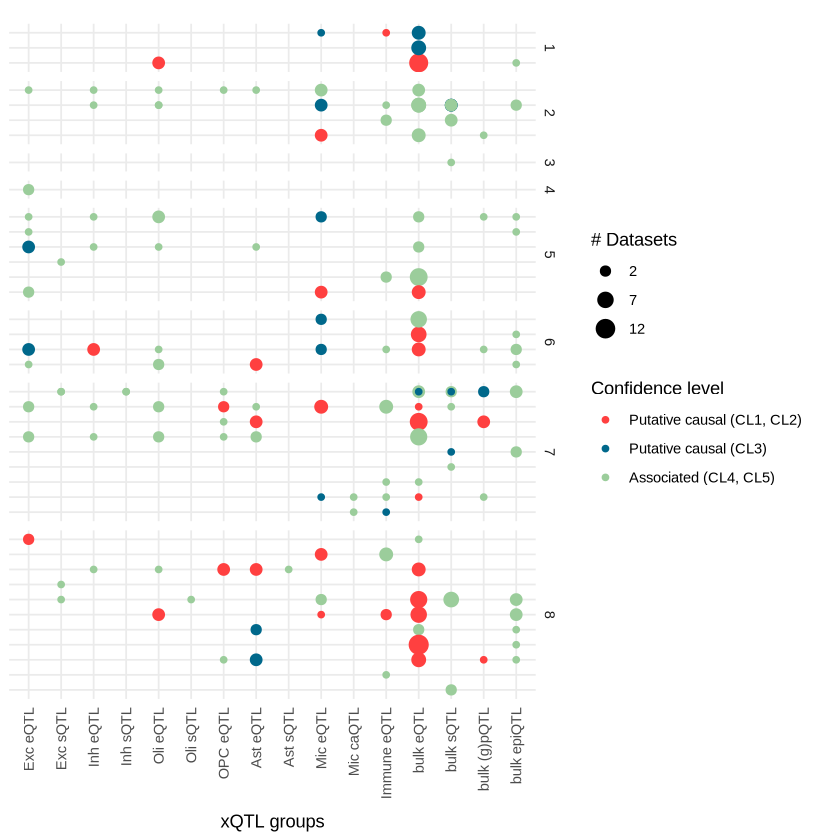

In [11]:
p1<-ggplot(res_adxlocge_cont_topf[chr%in%1:9][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))])+
  geom_point(aes(y=locus_gene_3,x=context_group,
                 size=n_study_group.locus,
                 col=confidence_cat_group))+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  scale_size(range = c(1.5,5),breaks = c(2,7,12))+theme_minimal()+
  scale_x_discrete(guide = guide_axis(angle = 90))+
  theme(strip.text.x = element_text(angle = 90))+
  labs(size='# Datasets',col='Confidence level')+
  xlab("xQTL groups") +
  scale_color_manual(values = c('brown1','deepskyblue4','darkseagreen3'))+ 
  theme(strip.text.x = element_text(angle = 90),
        axis.text.y = element_blank(),  # Changed from element_markdown()
        axis.title.y = element_blank()) +
  scale_y_discrete(labels=function(x) parse(text = x))  # Added parse()
p1
                   
g1 <- ggplot(res_adxloc_gwasf[chr%in%1:9])+
  geom_point(aes(y=locus_gene_3,x=gwas_short2,
                 col=gwas_sig),size=1,shape=15)+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  labs(col = "GWAS significance") + 
  xlab("AD GWAS") +
  scale_x_discrete(guide = guide_axis(angle = 90), labels = scales::label_parse())+  # Parse x labels
  scale_y_discrete(labels = scales::label_parse())+  # Parse y labels
  scale_color_manual(values = c('grey','bisque3','orange3','brown4'),
                     labels = c("p>1e-5 and colocalized", "p<1e-5", "p<1e-6","p<5e-8"))+
  theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1),
        axis.text.y = element_text(size=7),
        axis.title.y = element_blank(),
        strip.text = element_blank(),
        strip.background = element_blank())

In [12]:
#P1<-g1+p1+plot_layout(guides = 'collect',widths = c(1.5,6))&
#   theme(plot.margin = margin(0, 0, 0, 0)) 

#options(repr.plot.width = 10, repr.plot.height = 12)
#P1

#### Plot (chr10-22)

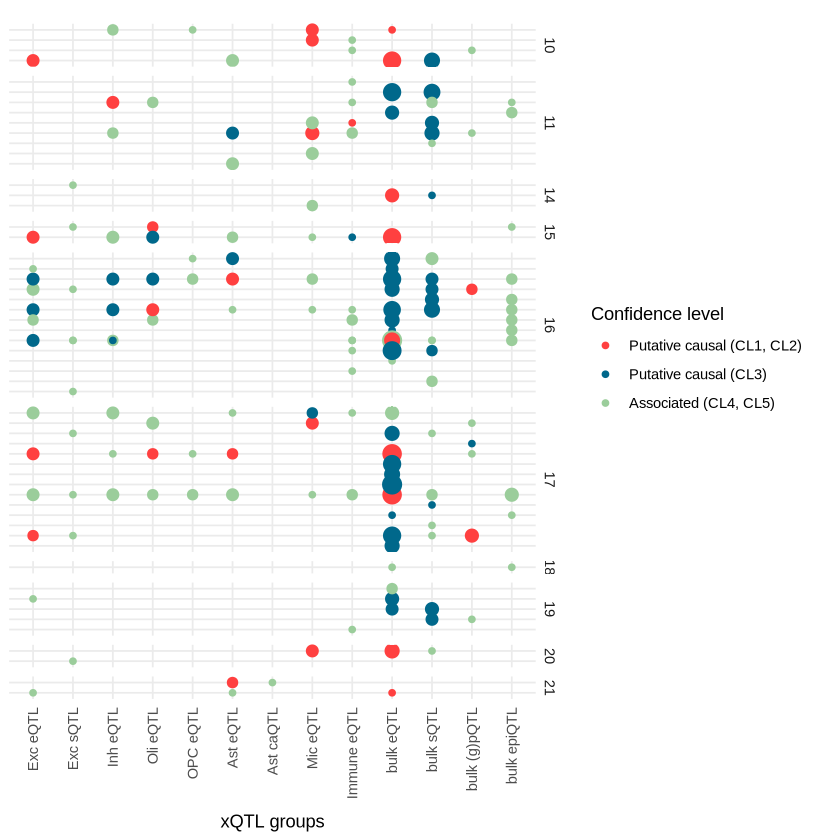

In [14]:
p2<-ggplot(res_adxlocge_cont_topf[chr%in%10:22][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))])+
  geom_point(aes(y=locus_gene_3,x=context_group,
                 size=n_study_group.locus,
                 col=confidence_cat_group))+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  scale_size(range = c(1.5,5),breaks = c(2,7,12))+theme_minimal()+
  scale_x_discrete(guide = guide_axis(angle = 90))+
  theme(strip.text.x = element_text(angle = 90))+
  labs(col='Confidence level') +
  xlab("xQTL groups") +
  scale_color_manual(values = c('brown1','deepskyblue4','darkseagreen3'))+ 
  theme(strip.text.x = element_text(angle = 90),
        axis.text.y = element_blank(),  # Changed from element_markdown()
        axis.title.y = element_blank())+
  scale_y_discrete(labels=function(x) parse(text = x)) +  # Changed from str_remove to parse
  guides(size = "none") 
p2

g2 <- ggplot(res_adxloc_gwasf[chr%in%10:22])+
  geom_point(aes(y=locus_gene_3,x=gwas_short2,
                 col=gwas_sig),size=1,shape=15)+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  labs(col = "GWAS significance") + 
  xlab("AD GWAS") + 
  scale_x_discrete(guide = guide_axis(angle = 90), labels = scales::label_parse())+  # Parse x labels
  scale_y_discrete(labels = scales::label_parse())+  # Parse y labels
  scale_color_manual(values = c('grey','bisque3','orange3','brown4'),           
                     labels = c("p>1e-5 and colocalized", "p<1e-5", "p<1e-6","p<5e-8"))+
  theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1),
        axis.text.y = element_text(size=7),
        axis.title.y = element_blank(),
        strip.text = element_blank(),
        strip.background = element_blank())


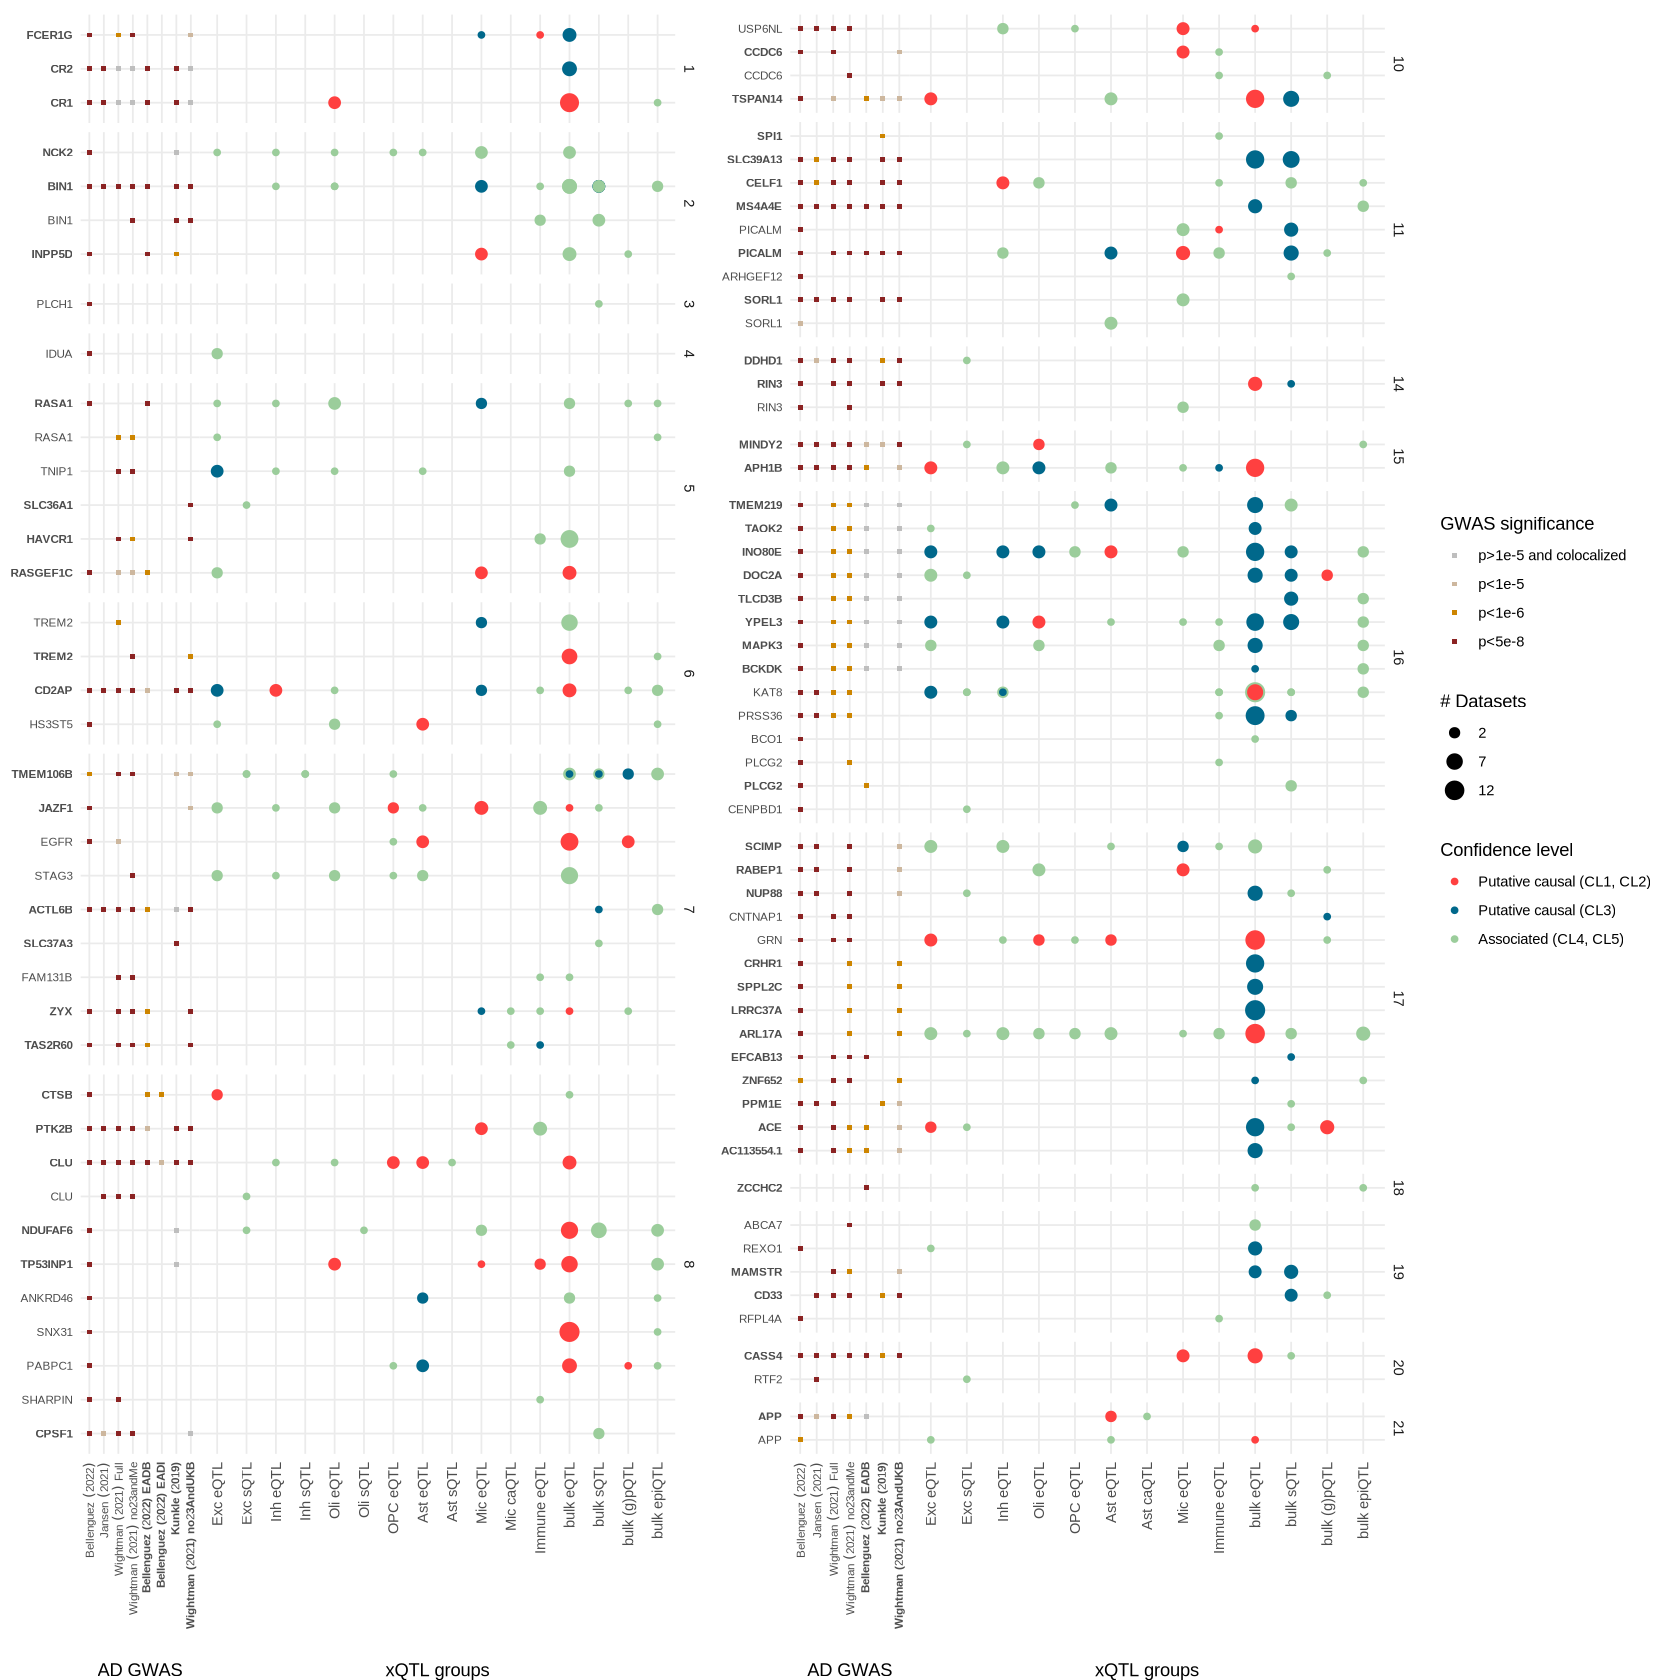

In [15]:
options(repr.plot.width = 14, repr.plot.height = 14)
g1+p1+g2+p2+plot_layout(guides = 'collect',widths = c(1.5,6,1.5,6))&
  theme(plot.margin = margin(0, 0, 0, 0)) 

#ggsave(fp(out,'ADloci_xQTL_summary_genome_wide_signif_top_gene_per_locus_3categories_gwas_plot_top_CL_genes_all_causal_top1_associated.pdf'),height = 9,width = 10)
#ggsave(fp(out,'ADloci_xQTL_summary_genome_wide_signif_top_gene_per_locus_3categories_gwas_plot_top_CL_genes_all_causal_top1_associated.png'),height = 9,width = 10)

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 38; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 42; recycled with remainder.”


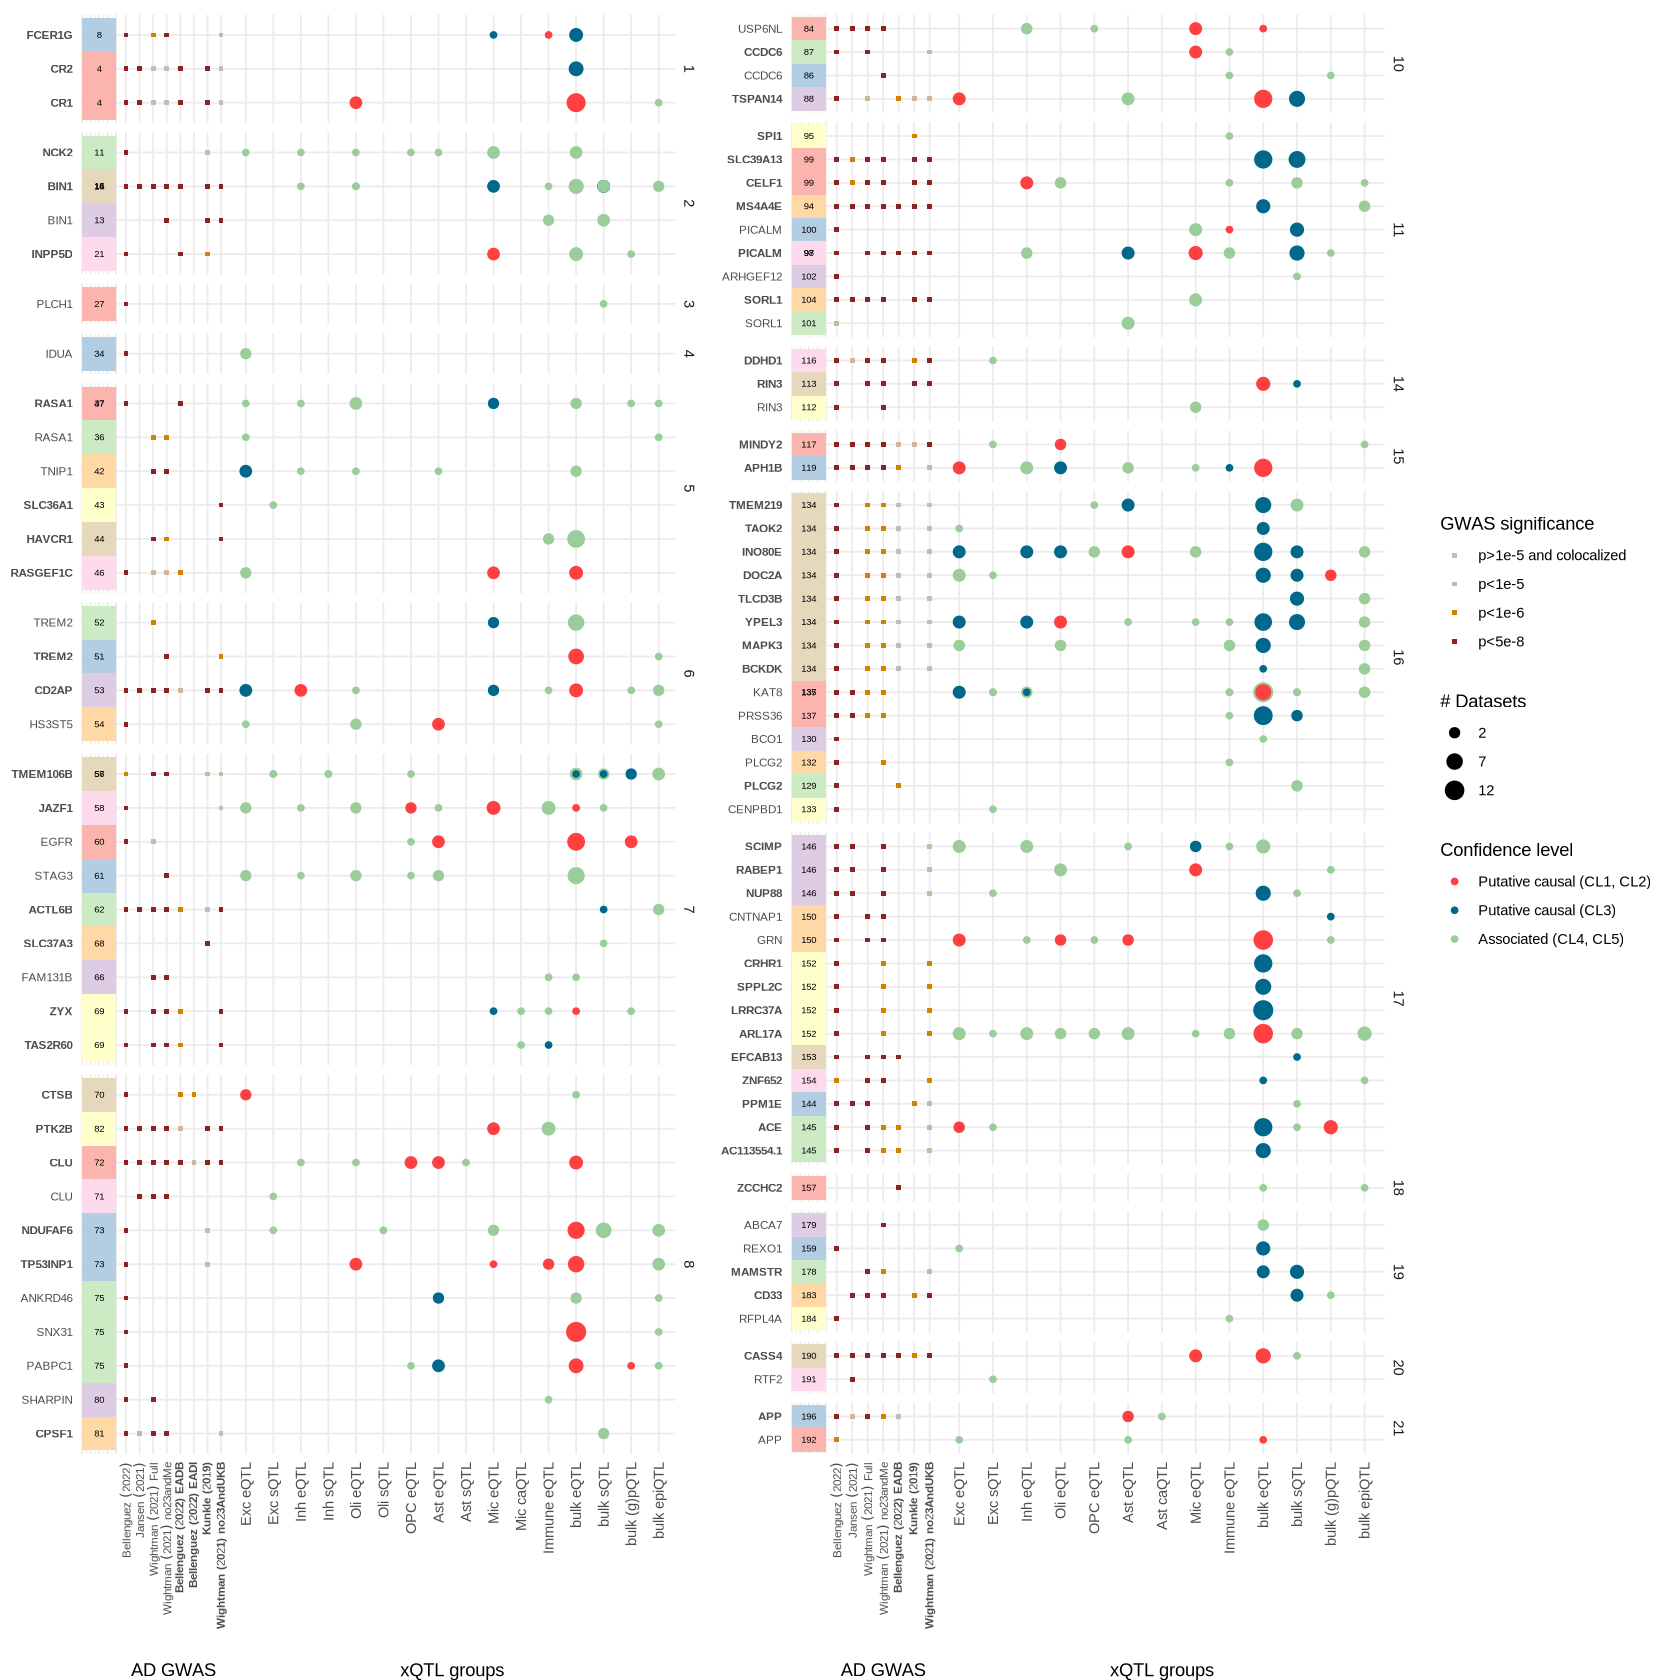

In [17]:
#add the locus number
g1 <- g1+theme(axis.text.y = element_blank())
g2 <- g2+theme(axis.text.y = element_blank())

# display.brewer.all(type = "qual")
palette = brewer.pal(8, "Pastel1")

cols1 <- data.table(locus_index=unique(res_adxlocge_cont_topf[chr%in%1:9][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))]$locus_index), color=palette)
l1 <- ggplot(unique(res_adxlocge_cont_topf[chr%in%1:9][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))],
                  by=c('locus_index','gene_name')),
           aes(x=0,y=locus_gene_3))+
  geom_tile(aes(fill=as.factor(locus_index)))+
  scale_fill_manual(values = setNames(cols1$color,as.character(cols1$locus_index)))+
  geom_text(aes(label=locus_index), size=2, fontface="plain")+  # Add fontface="plain"
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  scale_y_discrete(labels = scales::label_parse())+
  theme(axis.text.y = element_text(size=7),
        axis.title.y = element_blank(), 
        strip.text = element_blank(),
        strip.background = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        legend.position = "none")


cols2 <- data.table(locus_index=unique(res_adxlocge_cont_topf[chr%in%10:22][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))]$locus_index), color=palette)

l2 <- ggplot(unique(res_adxlocge_cont_topf[chr%in%10:22][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))],
                  by=c('locus_index','gene_name')),
           aes(x=0,y=locus_gene_3))+
  geom_tile(aes(fill=as.factor(locus_index)))+
  scale_fill_manual(values = setNames(cols2$color,as.character(cols2$locus_index)))+
  geom_text(aes(label=locus_index), size=2, fontface="plain")+  # Add fontface="plain"
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  scale_y_discrete(labels = scales::label_parse())+
  theme(axis.text.y = element_text(size=7),
        axis.title.y = element_blank(),
        strip.text = element_blank(),
        strip.background = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        legend.position = "none")

combined <- l1+g1+p1+l2+g2+p2+plot_layout(guides = 'collect',widths = c(0.5,1.5,6,0.5,1.5,6))&
  theme(plot.margin = margin(0, 0, 0, 0)) 

combined
                   
ggsave(filename = fp(out, "AD_xQTL_GWAS_combined_figure_v1.pdf"),plot = combined, width = 16, height = 14,units = "in", dpi = 300)

#### With all genes

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 38; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 42; recycled with remainder.”


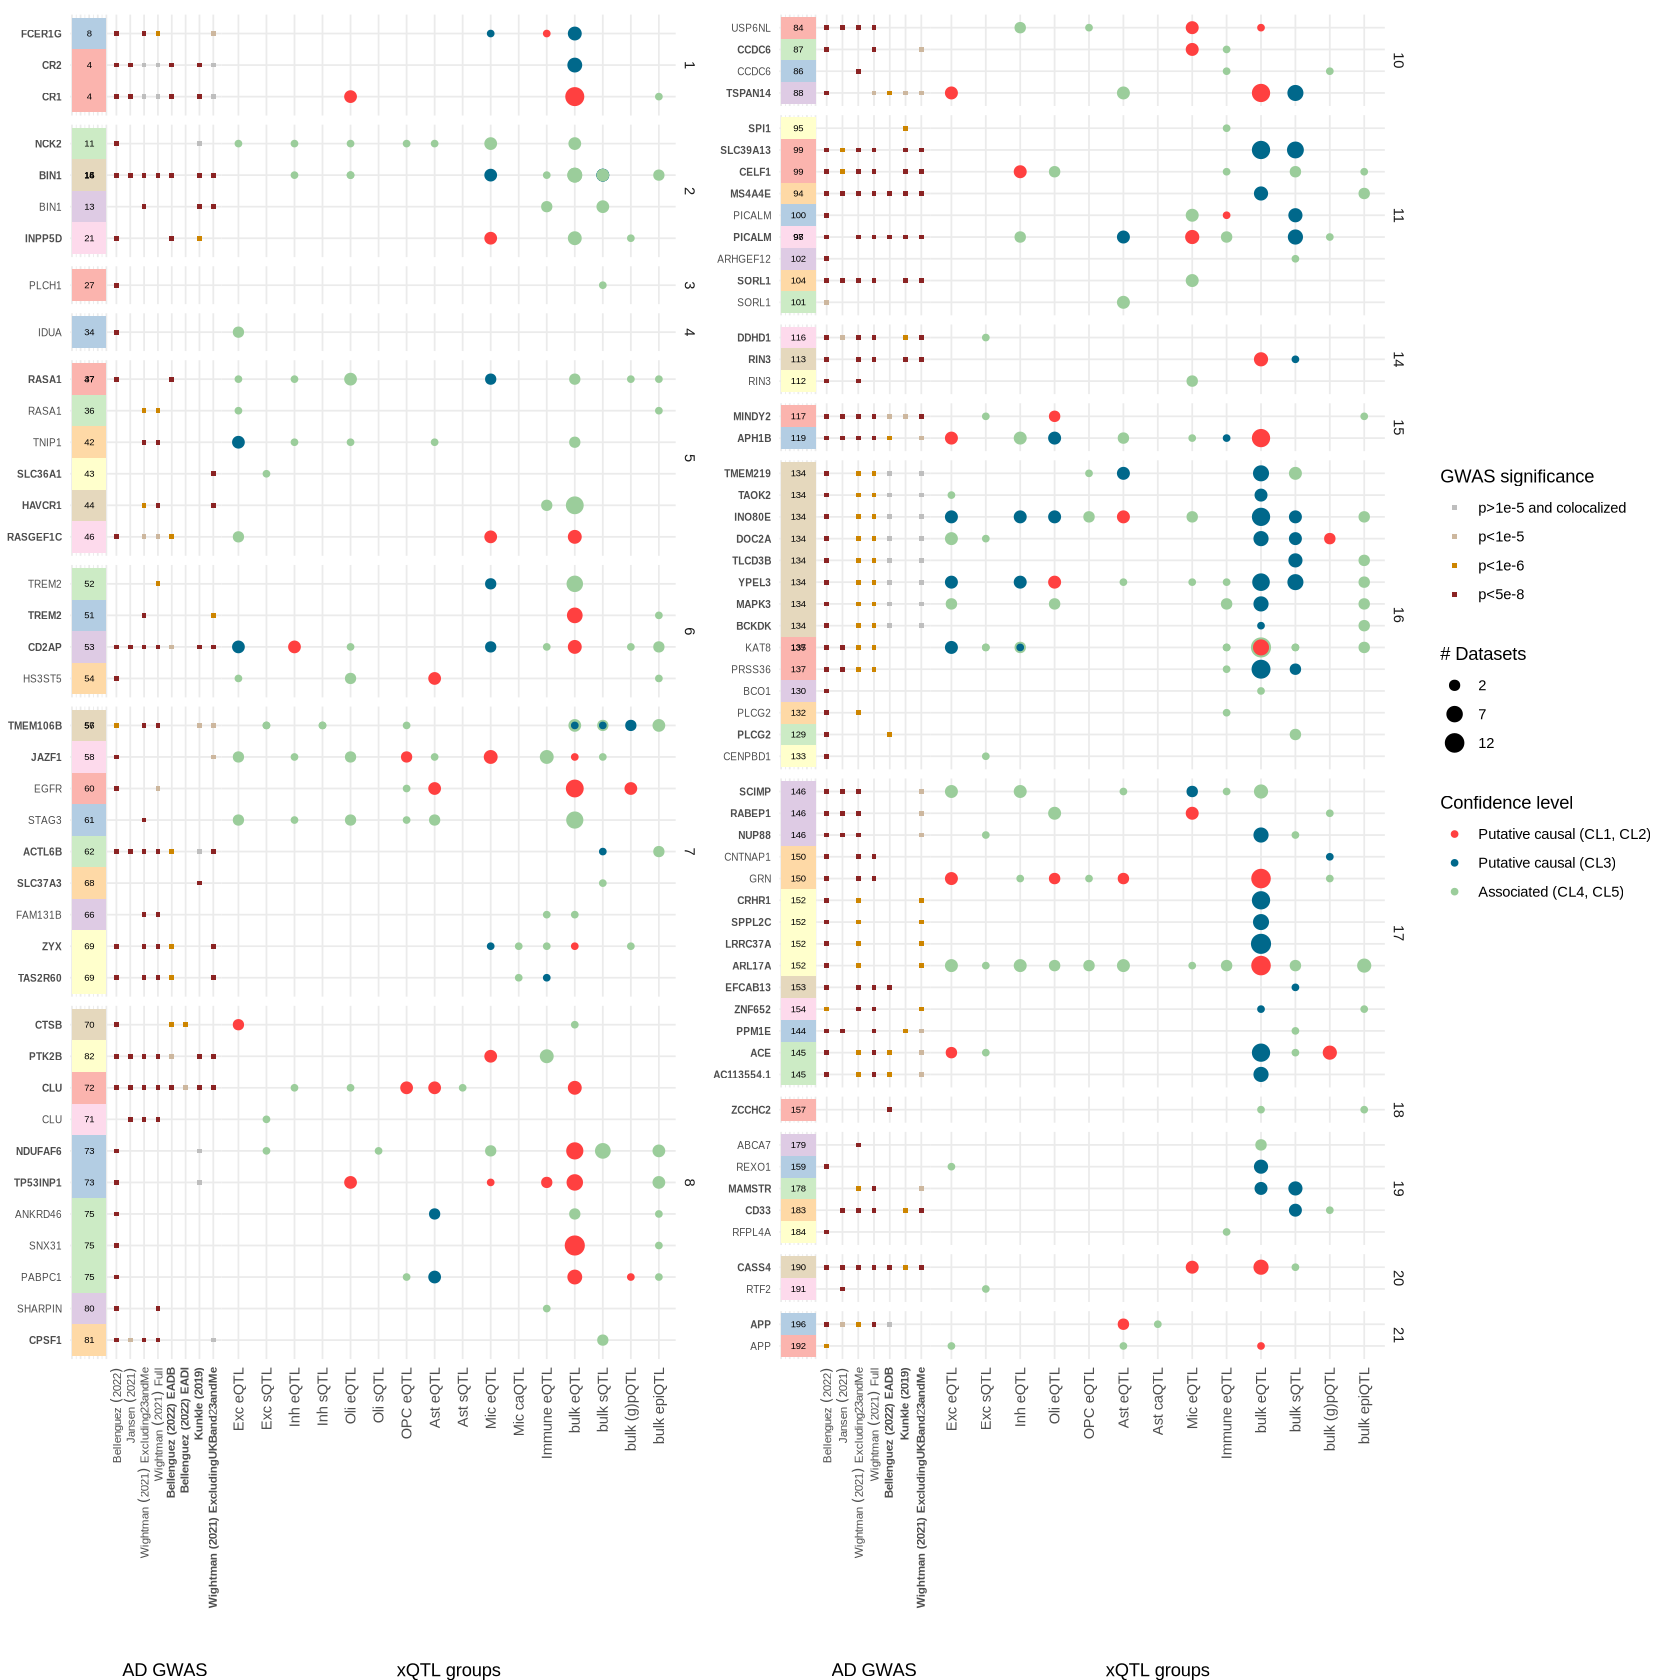

In [18]:
#filter the gwas and annot with the gene too
res_adxloc_gwasf<-merge(res_adxloc_gwas,unique(res_adxlocge_cont_topf[!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))][,.(locus_index,locus_gene_3,locus_gene)]),by='locus_index')

# clean gwas_source name - using plotmath for bold
clean_gwas_names_plotmath <- function(gwas_source) {
  case_when(
    gwas_source == "AD_Bellenguez_2022" ~ "Bellenguez~(2022)",
    gwas_source == "AD_Bellenguez_EADB_2022" ~ "bold(Bellenguez~'(2022)'~EADB)",
    gwas_source == "AD_Bellenguez_EADI_2022" ~ "bold(Bellenguez~'(2022)'~EADI)",
    gwas_source == "AD_Jansen_2021" ~ "Jansen~(2021)",
    gwas_source == "AD_Kunkle_Stage1_2019" ~ "bold(Kunkle~'(2019)')",
    gwas_source == "AD_Wightman_Excluding23andMe_2021" ~ "Wightman~(2021)~Excluding23andMe",
    gwas_source == "AD_Wightman_ExcludingUKBand23andME_2021" ~ "bold(Wightman~'(2021)'~ExcludingUKBand23andMe)",
    gwas_source == "AD_Wightman_Full_2021" ~ "Wightman~(2021)~Full",
    TRUE ~ gwas_source
  )
}

# Apply the transformation to your data
res_adxloc_gwasf$gwas_short2 <- clean_gwas_names_plotmath(res_adxloc_gwasf$gwas_source)

#chr1-9
p1<-ggplot(res_adxlocge_cont_topf[chr%in%1:9][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))])+
  geom_point(aes(y=locus_gene_3,x=context_group,
                 size=n_study_group.locus,
                 col=confidence_cat_group))+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  scale_size(range = c(1.5,5),breaks = c(2,7,12))+theme_minimal()+
  scale_x_discrete(guide = guide_axis(angle = 90))+
  theme(strip.text.x = element_text(angle = 90))+
  labs(size='# Datasets',col='Confidence level')+
  xlab("xQTL groups") +
  scale_color_manual(values = c('brown1','deepskyblue4','darkseagreen3'))+ 
  theme(strip.text.x = element_text(angle = 90),
        axis.text.y = element_blank(),
        axis.title.y = element_blank())

g1<-ggplot(res_adxloc_gwasf[chr%in%1:9])+
  geom_point(aes(y=locus_gene_3,x=gwas_short2,
                 col=gwas_sig),size=1,shape=15)+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  scale_x_discrete(guide = guide_axis(angle = 90), labels = scales::label_parse())+
  scale_y_discrete(labels = scales::label_parse())+
  scale_color_manual(
    values = c('grey','bisque3','orange3','brown4'),
    labels = c("p>1e-5 and colocalized", "p<1e-5", "p<1e-6","p<5e-8")) +
  labs(col = "GWAS significance") +
  xlab("AD GWAS") + 
  theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1),
        axis.text.y = element_text(size=7),
        axis.title.y = element_blank(),
        strip.text = element_blank(),
        strip.background = element_blank())

#chr10-22
p2<-ggplot(res_adxlocge_cont_topf[chr%in%10:22][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))])+
  geom_point(aes(y=locus_gene_3,x=context_group,
                 size=n_study_group.locus,
                 col=confidence_cat_group))+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  scale_size(range = c(1.5,5),breaks = c(2,7,12))+theme_minimal()+
  scale_x_discrete(guide = guide_axis(angle = 90))+
  theme(strip.text.x = element_text(angle = 90))+
  labs(col='Confidence level')+
  xlab("xQTL groups") +
  scale_color_manual(values = c('brown1','deepskyblue4','darkseagreen3'))+ 
  theme(strip.text.x = element_text(angle = 90),
        axis.text.y = element_blank(),
        axis.title.y = element_blank())+
  guides(size = "none")

g2<-ggplot(res_adxloc_gwasf[chr%in%10:22])+
  geom_point(aes(y=locus_gene_3,x=gwas_short2,
                 col=gwas_sig),size=1,shape=15)+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  scale_x_discrete(guide = guide_axis(angle = 90), labels = scales::label_parse())+
  scale_y_discrete(labels = scales::label_parse())+
  scale_color_manual(
    values = c('grey','bisque3','orange3','brown4'),
    labels = c("p>1e-5 and colocalized", "p<1e-5", "p<1e-6","p<5e-8"))+
  labs(col = "GWAS significance") +
  xlab("AD GWAS") +
  theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1),
        axis.text.y = element_text(size=7),
        axis.title.y = element_blank(),
        strip.text = element_blank(),
        strip.background = element_blank())

#add the tile of the locus number
g1<-g1+theme(axis.text.y = element_blank())
g2<-g2+theme(axis.text.y = element_blank())

palette=brewer.pal(8, "Pastel1")
cols1 <- data.table(locus_index=unique(res_adxlocge_cont_topf[chr%in%1:9][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))]$locus_index),
                    color=palette)

l1<-ggplot(unique(res_adxlocge_cont_topf[chr%in%1:9][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))],
                  by=c('locus_index','gene_name')),
           aes(x=0,y=locus_gene_3))+
  geom_tile(aes(fill=as.factor(locus_index)))+
  scale_fill_manual(values = setNames(cols1$color,as.character(cols1$locus_index)))+
  geom_text(aes(label=locus_index),size=2, fontface="plain")+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  scale_y_discrete(labels = scales::label_parse())+
  theme(axis.text.y = element_text(size=6),
        axis.title.y = element_blank(), 
        strip.text = element_blank(),
        strip.background = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        legend.position = "none")

cols2 <- data.table(locus_index=unique(res_adxlocge_cont_topf[chr%in%10:22][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))]$locus_index),
                    color=palette)

l2<-ggplot(unique(res_adxlocge_cont_topf[chr%in%10:22][!(APOE_region.gene)&(top_gene|top_confidence%in%c("CL1",'CL2','CL3'))],
                  by=c('locus_index','gene_name')),
           aes(x=0,y=locus_gene_3))+
  geom_tile(aes(fill=as.factor(locus_index)))+
  scale_fill_manual(values = setNames(cols2$color,as.character(cols2$locus_index)))+
  geom_text(aes(label=locus_index),size=2, fontface="plain")+
  facet_grid(chr~'',scales = 'free',space = 'free')+
  theme_minimal()+
  scale_y_discrete(labels = scales::label_parse())+
  theme(axis.text.y = element_text(size=6),
        axis.title.y = element_blank(),
        strip.text = element_blank(),
        strip.background = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        legend.position = "none")

options(repr.plot.width = 14, repr.plot.height = 14)
combined_with_all_genes <- l1+g1+p1+l2+g2+p2+plot_layout(guides = 'collect',widths = c(0.5,1.5,6,0.5,1.5,6))&
  theme(plot.margin = margin(0, 0, 0, 0)) 

combined_with_all_genes
                   
ggsave(filename = fp(out, "AD_xQTL_GWAS_combined_figure_with_all_genes.pdf"),plot = combined_with_all_genes, width = 16, height = 14,units = "in", dpi = 300)

#### With all all genes

In [19]:
#get GWAS signals
res_ad<-fread(fp(out,'AD_loci_unified_cs95orColocs.csv.gz'))
res_ad<-merge(res_ad,unique(res_adx[,.(locus_index,ADlocusID)]))
res_ad[,gwas_pvalue:=getPval(gwas_zscore)]
res_adxloc_gwas<-unique(res_ad[order(gwas_pvalue)][gwas_source!=''],by=c('locus_index','gwas_source'))
res_adxloc_gwas[,chr:=str_extract(chr,'[0-9]+')|>as.numeric()]
res_adxloc_gwas[,gwas_pvalue10:=ifelse(gwas_pvalue>1e-10,gwas_pvalue,1e-10)]
res_adxloc_gwas[,gwas_sig:=ifelse(gwas_pvalue<5e-8,'p<5e-8',ifelse(gwas_pvalue<1e-6,'p<1e-6',ifelse(gwas_pvalue<1e-5,'p<1e-5',
                                                                                                    'p>1e-5 but coloc')))]
res_adxloc_gwas[is.na(gwas_sig),gwas_sig:='p>1e-5 but coloc']
res_adxloc_gwas[,gwas_sig:=factor(gwas_sig,levels=c('p>1e-5 but coloc','p<1e-5','p<1e-6','p<5e-8'))]
res_adxloc_gwas[,gwas_short:=str_extract(gwas_source,'Bellenguez|Jansen|Kunkle|Wightman')]
table(res_adxloc_gwas$gwas_short)
res_adxloc_gwas[str_detect(gwas_source,'EADB|EADI|UKB|23andMe'),gwas_short:=paste(gwas_short,str_extract(gwas_source,'EADB|EADI|UKB|23andMe'),sep='_')]
res_adxloc_gwas[gwas_short=='Wightman_23andMe',gwas_short:='Wightman_no23andMe']
res_adxloc_gwas[gwas_short=='Wightman_UKB',gwas_short:='Wightman_no23AndUKB']
#order by n AD cases (non AD by proxi first) 
res_adxloc_gwas[,ad_by_proxi:=!gwas_source%in%c('AD_Bellenguez_EADB_2022','AD_Bellenguez_EADI_2022',
                                                'AD_Wightman_ExcludingUKBand23andME_2021',
                                                'AD_Kunkle_Stage1_2019'),by='locus_index']
gwmt<-fread(fp(out,'gwas_n_cases_control.tsv'))
res_adxloc_gwas<-merge(res_adxloc_gwas,gwmt[,.(gwas_source=study_id,n_case,n_control)])

# Get proxy status for loci
locus_proxy_status <- unique(res_adxloc_gwas[, .(locus_index, ad_by_proxi)])

#fwrite(res_adxloc_gwas,fp(out,'res_summ_all_gwas_by_locus.csv.gz'))


Bellenguez     Jansen     Kunkle   Wightman 
       180         36         42        211 

In [20]:
res_adxloc_gwas[,gwas_short2:=factor(gwas_short,levels = unique(gwas_short[order(ad_by_proxi,-n_case)]))]
levels(res_adxloc_gwas$gwas_short2)
# group some contexts
res_adxloc[,context_group:=ifelse(context_short%in%c('bMono eQTL','bMac eQTL','bMic eQTL'),'Immune eQTL',
                                    ifelse(context_short%in%c( 'bulk p-sQTL','bulk u-sQTL','bulk a-sQTL'),'bulk sQTL',
                                           ifelse(context_short%in%c('bulk pQTL','bulk gpQTL'),'bulk (g)pQTL',
                                                  ifelse(context_short%in%c('bulk haQTL','bulk mQTL'),'bulk epiQTL',as.character(context_short)))))]
res_adxloc<-res_adxloc[context_group!='']
# summarize using confidence score  and nstudy
res_adxloc[,n_study_group:=length(unique(context)),by=.(gene_name,context_group)]
res_adxloc[,confidence_lvl_group:=sort(confidence_lvl)[1],by=.(gene_name,context_group)]
res_adxloc[,n_loci_gene:=unique(locus_index)|>length(),by=.(gene_name)]
res_adxloc[,n_study_group.locus:=length(unique(context)),by=.(gene_name,locus_index,context_group)]
res_adxloc[,confidence_lvl_group.locus:=sort(confidence_lvl)[1],by=.(gene_name,locus_index,context_group)]


[1] "Wightman_no23AndUKB" "Kunkle"              "Bellenguez_EADB"    
[4] "Bellenguez_EADI"     "Bellenguez"          "Wightman"           
[7] "Wightman_no23andMe"  "Jansen"

In [21]:
contexts_order<-c('Exc eQTL','Exc sQTL',
                  'Inh eQTL','Inh sQTL',
                  'Oli eQTL','Oli sQTL',
                  'OPC eQTL','OPC sQTL',
                  'Ast eQTL','Ast caQTL','Ast sQTL',
                  'Mic eQTL','Mic caQTL', 'Mic sQTL',
                  'Immune eQTL',
                  'bulk eQTL',
                  'bulk sQTL',
                  'bulk (g)pQTL',
                  'bulk epiQTL')
setdiff(res_adxloc$context_group,contexts_order)
res_adxloc[,context_group:=factor(context_group,levels = contexts_order)]


character(0)

In [22]:
#genome wide significant hits####
res_adxlocf<-res_adxloc[(genomewide_sig_gene)]
unique(res_adxlocf$locus_index)|>length()
unique(res_adxlocf$gene_name)|>length()
unique(res_adxlocf$locus_gene)|>length()
unique(res_adxlocf[!(APOE_region.gene)]$locus_gene)|>length()
# extract each locus
res_adxlocf_cont_top<-unique(res_adxlocf[order(confidence_lvl_group.locus)],by=c('gene_name','context_group','locus_index'))[gene_name%in%gene_name[confidence_lvl_group.locus%in%c('CL1','CL2','CL3','CL4','CL5')]]
#sep causal vs correlated and remove all C6
res_adxlocf_cont_topf<-res_adxlocf_cont_top[confidence_lvl_group.locus!='CL6']
#sep in 3categories
res_adxlocf_cont_topf[,confidence_cat_group:=ifelse(confidence_lvl_group.locus%in%c('CL1',"CL2"),'Putative causal (CL1, CL2)',ifelse(confidence_lvl_group.locus=='CL3','Putative causal (CL3)','Associated (CL4, CL5)'))]
res_adxlocf_cont_topf[,confidence_cat_group:=factor(confidence_cat_group,levels = c('Putative causal (CL1, CL2)','Putative causal (CL3)','Associated (CL4, CL5)'))]

# Add proxy status to genes data
res_adxlocf_cont_topf[locus_proxy_status, ad_by_proxi := i.ad_by_proxi, on = 'locus_index']

# Annot genes with plotmath for bold - NO locus number
res_adxlocf_cont_topf[,locus_gene_2:=gene_name, by=.(gene_name)]  # Just use gene name
res_adxlocf_cont_topf[,locus_gene_2:={
  base_text <- gene_name[1]  # Just the gene name, no numbering
  is_bold <- !ad_by_proxi[1]
  
  # Apply bold if needed - wrap gene name in quotes to bold numbers
  if(is_bold) {
    paste0("bold('", base_text, "')")
  } else {
    base_text
  }
}, by='locus_gene']

#order per gene tss and locus position
res_adxlocf_cont_topf[,locus_gene_3:=factor(locus_gene_2,levels = unique(locus_gene_2[order(chr,-tss,-min_pval)]))]

[1] 103

[1] 292

[1] 359

[1] 334

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 31; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 26; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 14; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 22; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 31; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 26; 

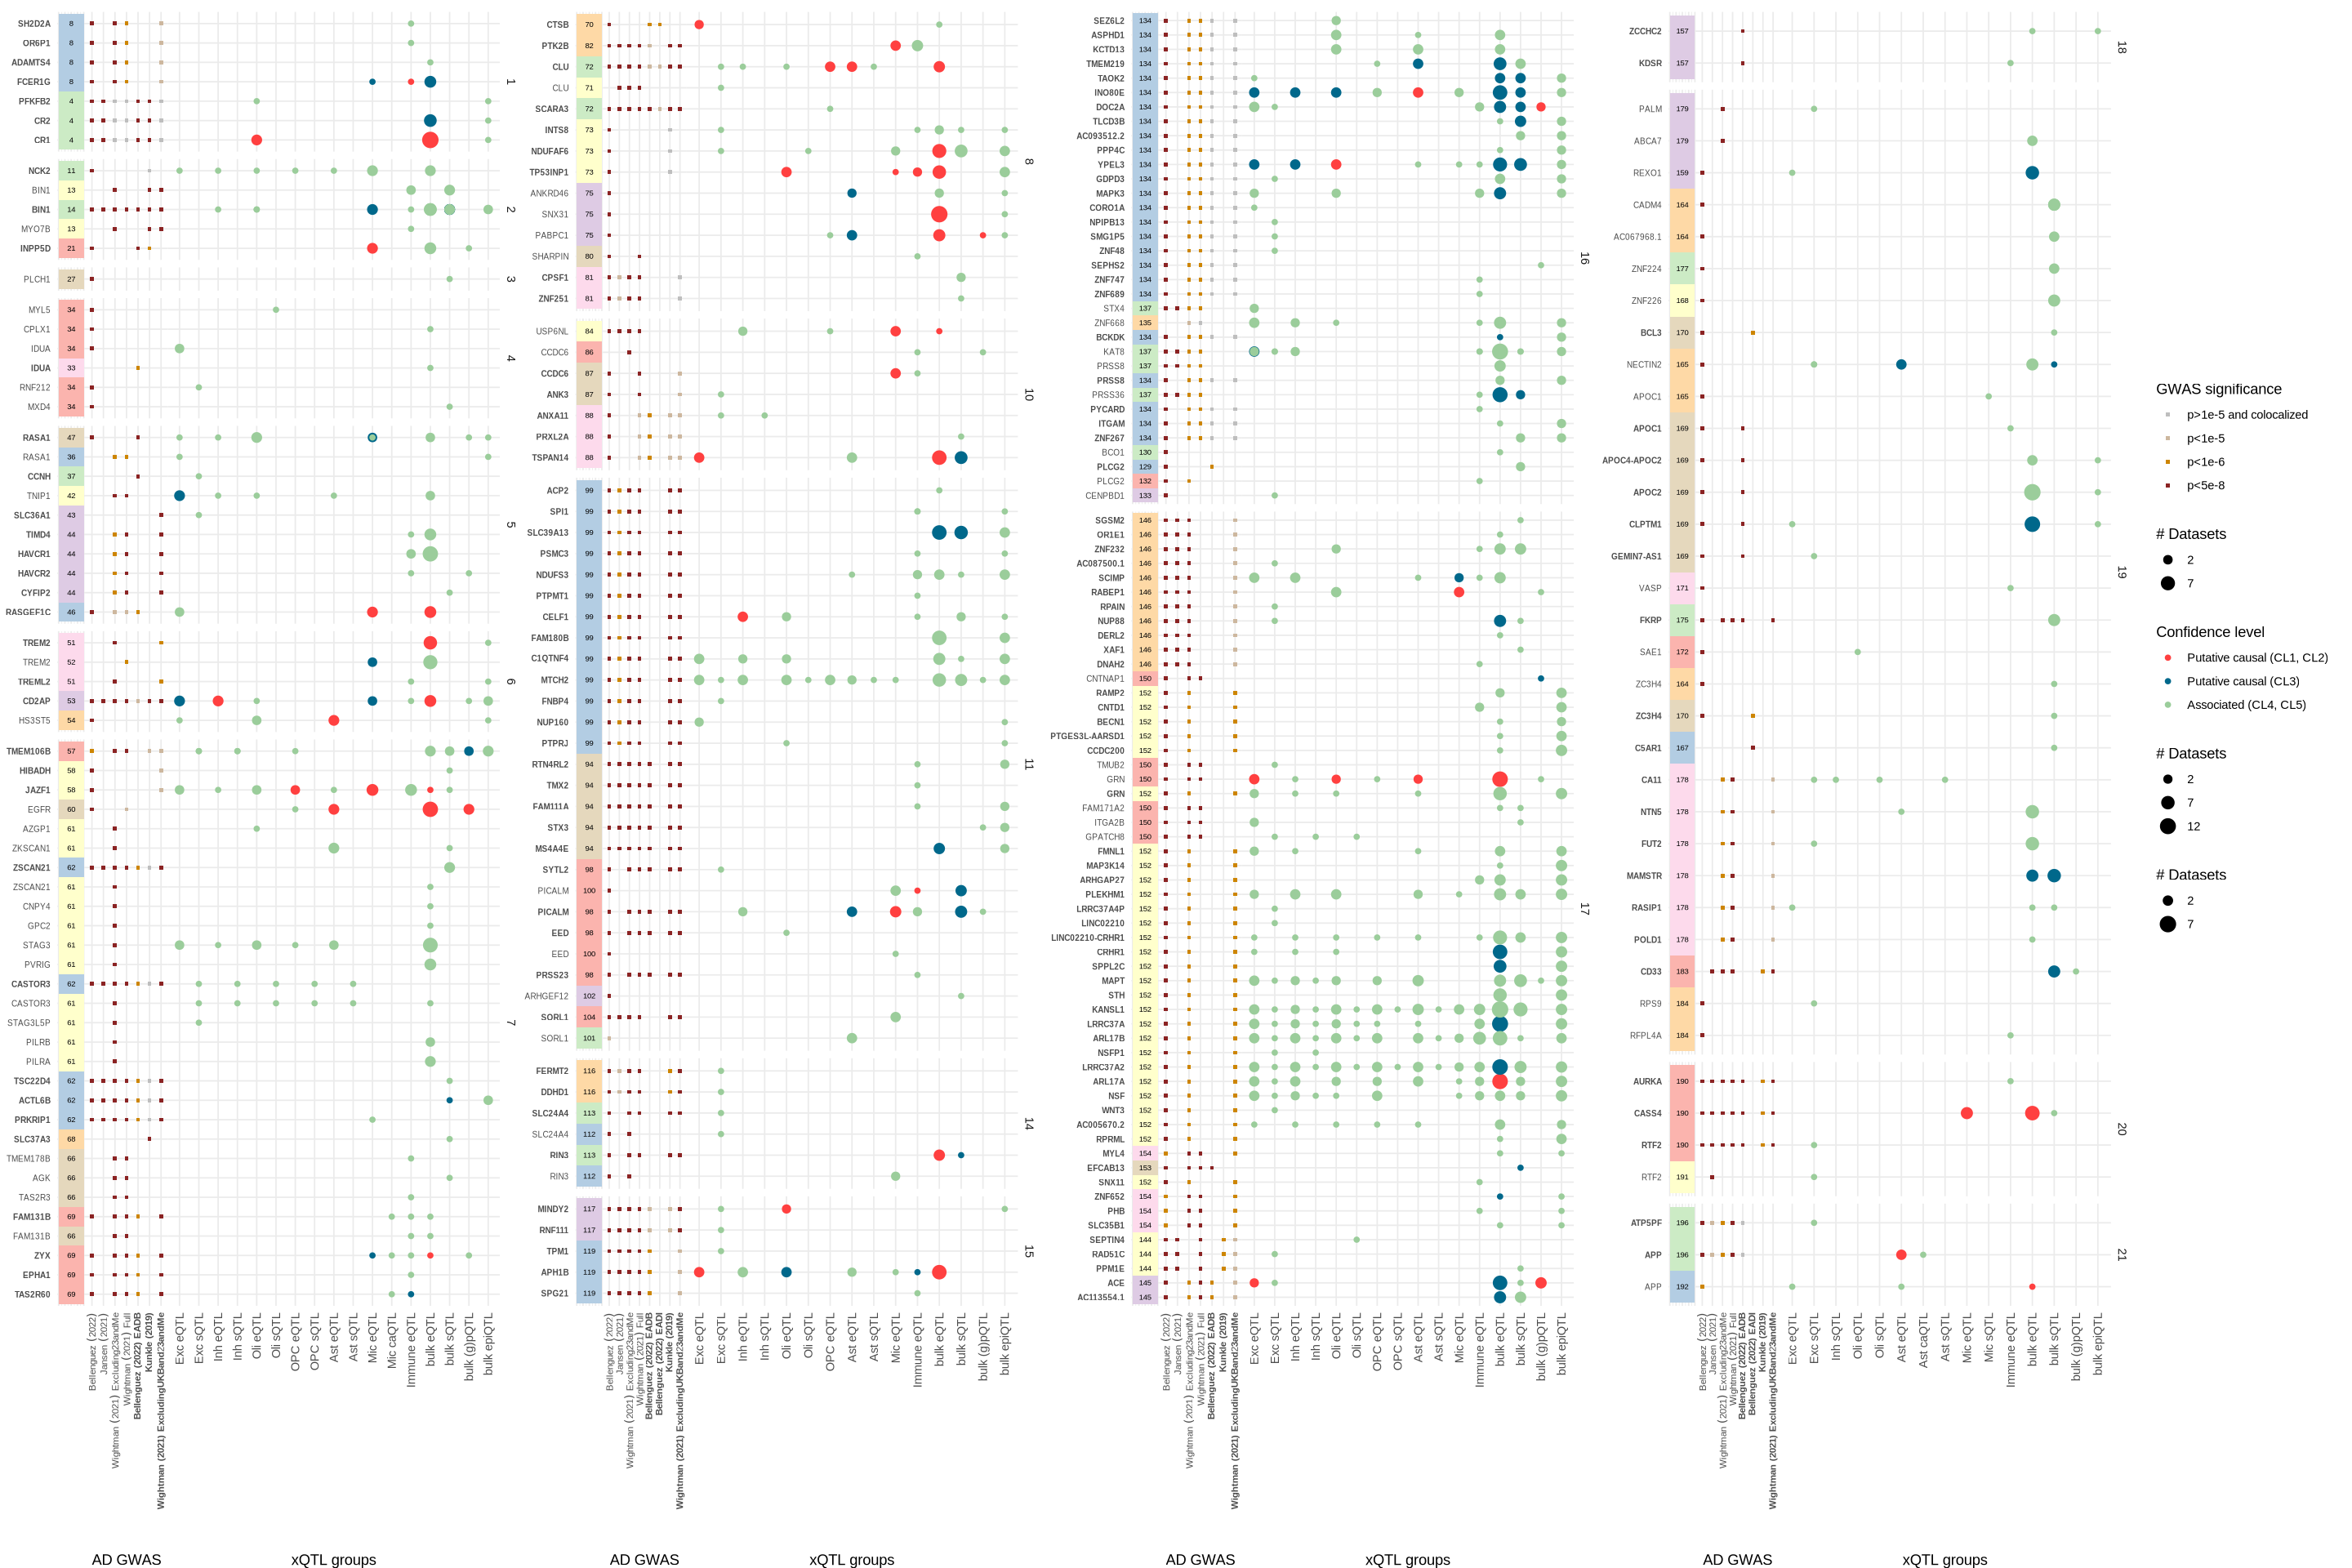

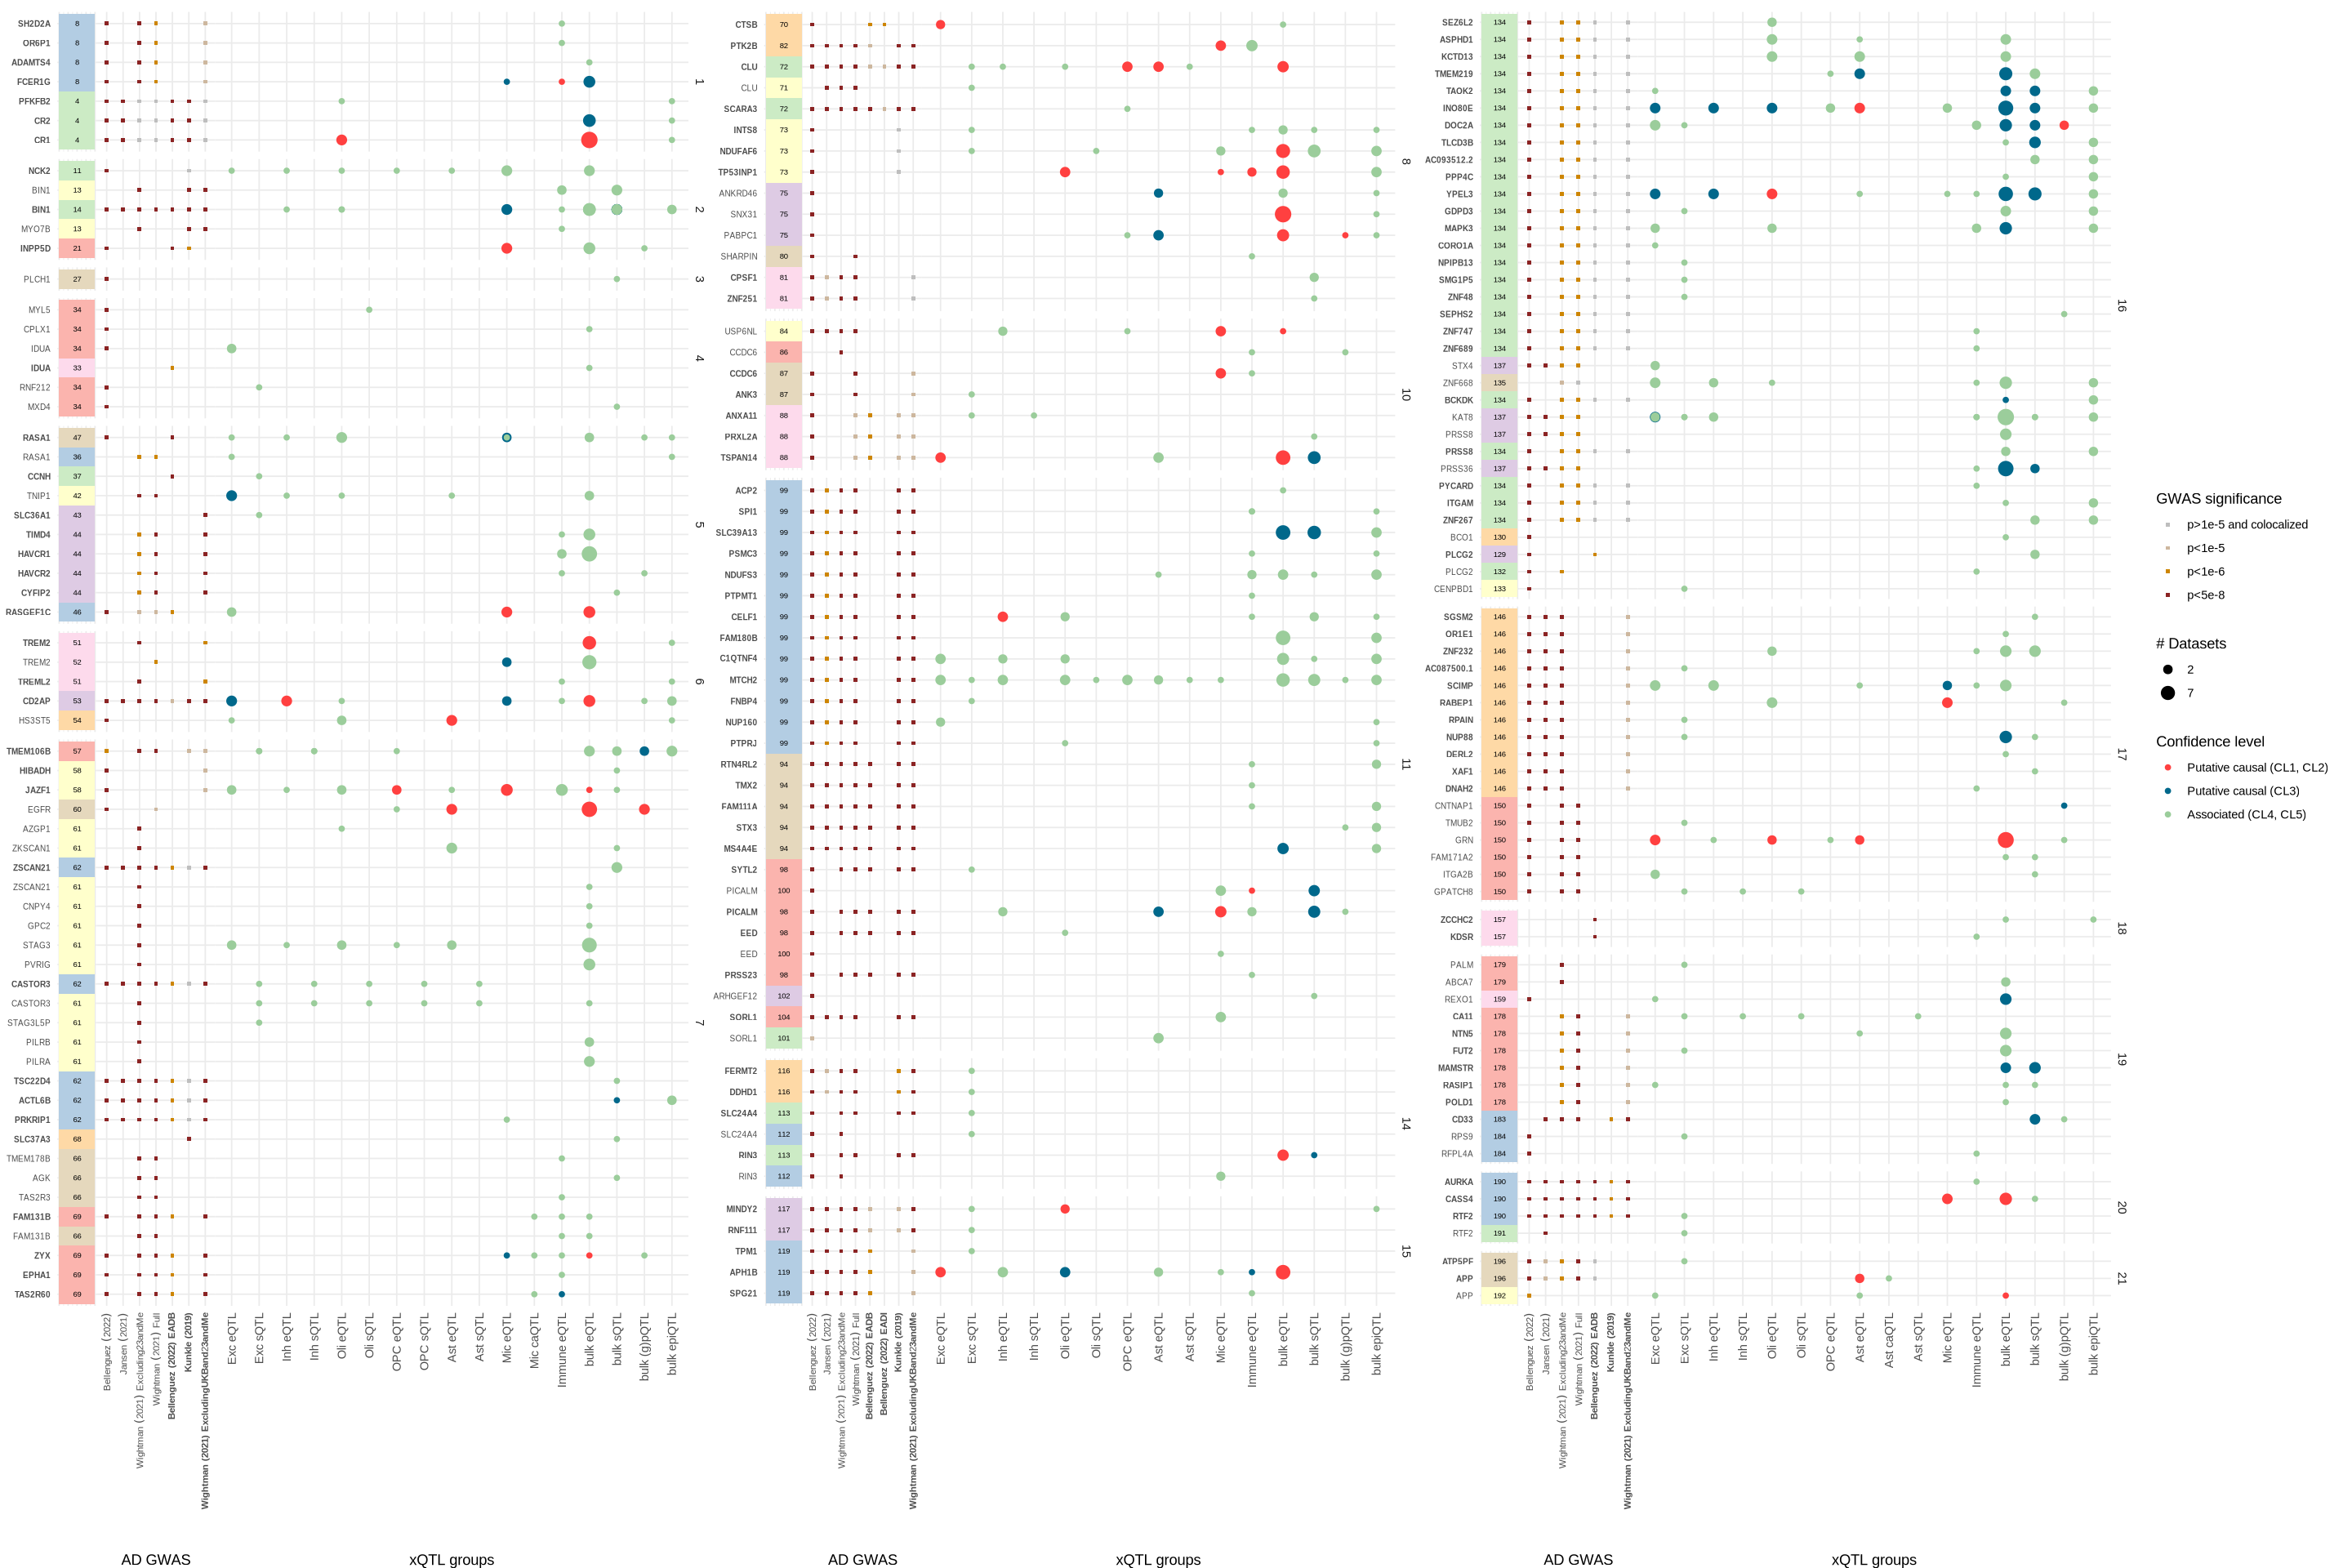

In [23]:
ps<-lapply(list(1:7,8:15,16:17,18:22), function(chrs){
  SummPanel(res_adxlocf_cont_topf[chr%in%chrs],res_adxloc_gwas)
})|>unlist(recursive = FALSE)
options(repr.plot.width = 24, repr.plot.height = 16)
wrap_plots(ps)+plot_layout(guides = 'collect',widths = rep(c(0.5,1.5,6),4))&
  theme(plot.margin = margin(0, 0, 0, 0)) 

#excluding APOE MAPT
splits<-list(1:7,8:15,16:22)
ps<-lapply(seq_along(splits), function(i) {
  chrs <- splits[[i]]
  show_size_legend <- ifelse(i == 1, TRUE, FALSE)
  SummPanel(res_adxlocf_cont_topf[chr%in%chrs][!(MAPT_region.locus|APOE_region.gene)], 
            res_adxloc_gwas, 
            show_size_legend = show_size_legend)
})|>unlist(recursive = FALSE)
options(repr.plot.width = 24, repr.plot.height = 16)
p3 <- wrap_plots(ps)+plot_layout(guides = 'collect',widths = rep(c(0.5,1.5,6),length(splits)))&
  theme(plot.margin = margin(0, 0, 0, 0))
p3
ggsave(filename = fp(out, "AD_xQTL_GWAS_with_all_all_genes.pdf"),plot = p3, width = 16, height = 14,units = "in", dpi = 300)

#### Suggestive signal
CL1 CL2 CL3 CL4 + more than 2 GWAS + at least 2 datasets in a similar context

In [24]:
res_adxlocf<-res_adxloc[!(genomewide_sig_gene)][gene_name%in%gene_name[confidence_lvl_group%in%c('CL1','CL2','CL3','CL4')&n_gwas_locus>2&n_study_group.locus>=2]]
res_adxlocf_cont<-unique(res_adxlocf,by=c('gene_name','context_group','locus_index'))

# Add proxy status to genes data
res_adxlocf_cont[locus_proxy_status, ad_by_proxi := i.ad_by_proxi, on = 'locus_index']

#sep causal vs correlated 
res_adxlocf_cont[,confidence_cat_group:=ifelse(confidence_lvl_group.locus%in%c('CL1',"CL2"),'Putative causal (CL1, CL2)',ifelse(confidence_lvl_group.locus=='CL3','Putative causal (CL3)','Associated (CL4, CL5)'))]
res_adxlocf_cont[,confidence_cat_group:=factor(confidence_cat_group,levels = c('Putative causal (CL1, CL2)','Putative causal (CL3)','Associated (CL4, CL5)'))]

#annot genes with plotmath for bold - NO locus number
res_adxlocf_cont[,locus_gene_2:={
  base_text <- gene_name[1]  # Just the gene name, no numbering
  is_bold <- !ad_by_proxi[1]
  
  # Apply bold if needed - wrap gene name in quotes to bold numbers
  if(is_bold) {
    paste0("bold('", base_text, "')")
  } else {
    base_text
  }
}, by='locus_gene']

#order per gene tss and locus position
res_adxlocf_cont[,locus_gene_3:=factor(locus_gene_2,levels = unique(locus_gene_2[order(chr,-tss,-min_pval)]))]

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 8 rows but longest item has 11; recycled with remainder.”


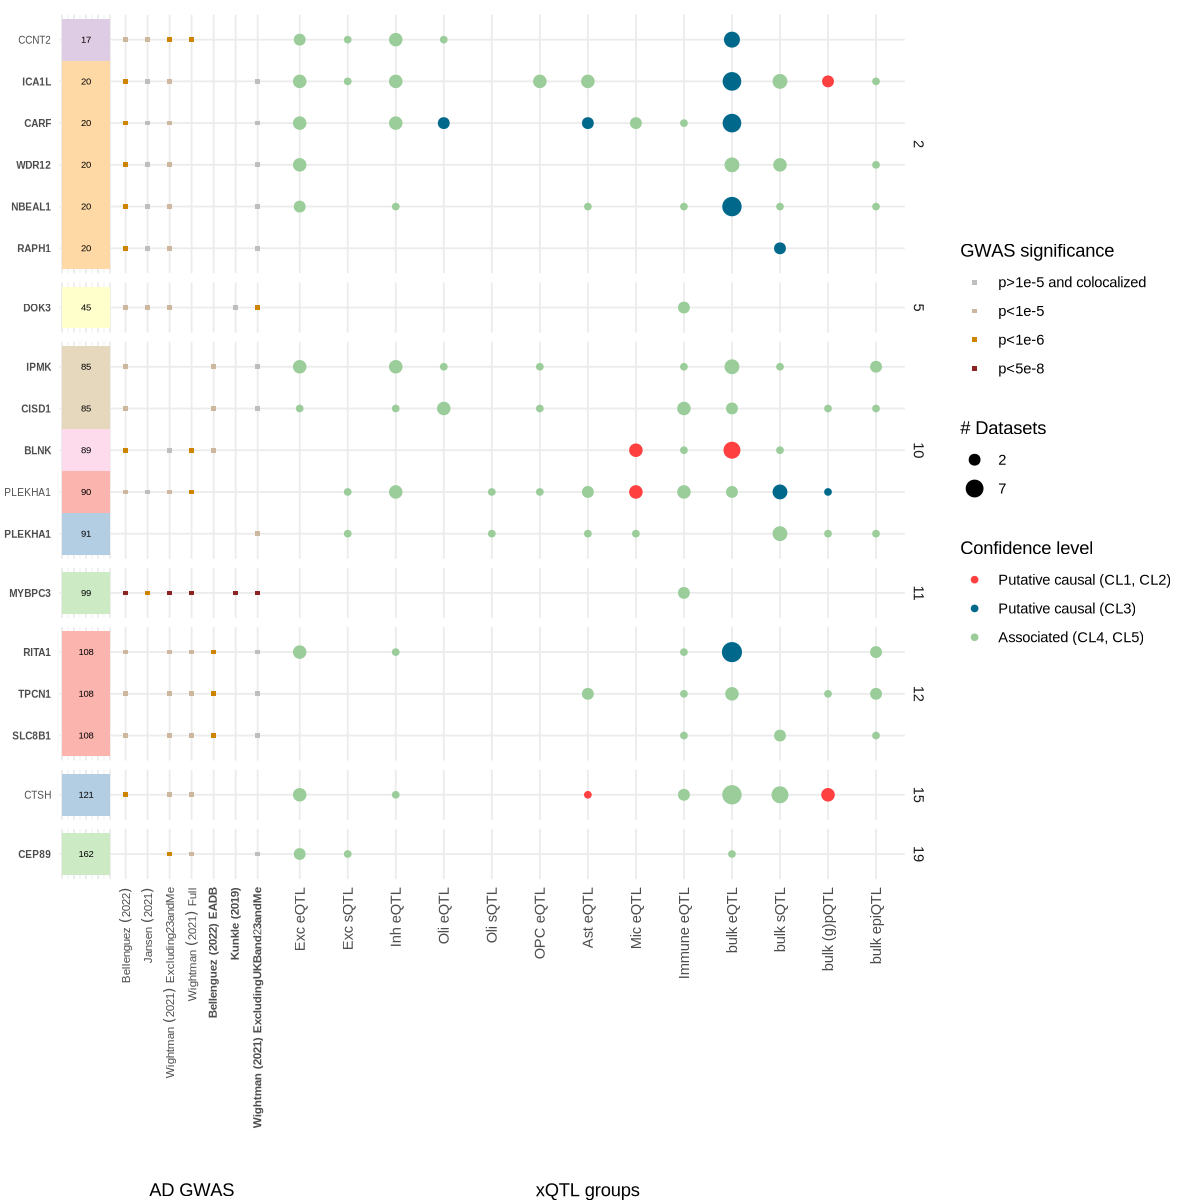

In [25]:
ps<-SummPanel(res_adxlocf_cont,res_adxloc_gwas)

options(repr.plot.width = 10, repr.plot.height = 10)
p4 <- wrap_plots(ps)+plot_layout(guides = 'collect',widths = c(0.5,1.5,6))&
  theme(plot.margin = margin(0, 0, 0, 0)) 
p4
ggsave(fp(out,'ADloci_xQTL_summary_suggestive_loci.png'),plot = p4,height = 5,width = 6)
